# A study on sampled networkx with 5.3K nodes
The networkx is sampled using a random walk with flying back method
when Evaluating a sample, we want to do the following:
1. comapre basic properties including: average degree, average strength. Must include visulization testing power law on degree and strength
2. a clustering coef vs degree plot 

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt 
import random
import time
import utils
import re
from collections import defaultdict

In [2]:
G_sample = nx.read_edgelist('data\RWMult_sample5.3K.edgelist', data=(("total",float),("count", int)), create_using=nx.DiGraph)
# some basic properties
utils.print_basic_properties(G_sample)

Number of nodes: 5201
Number of edges: 33678
Average degree: 12.950586425687368
Average clustering coefficient: 0.01630735040785356


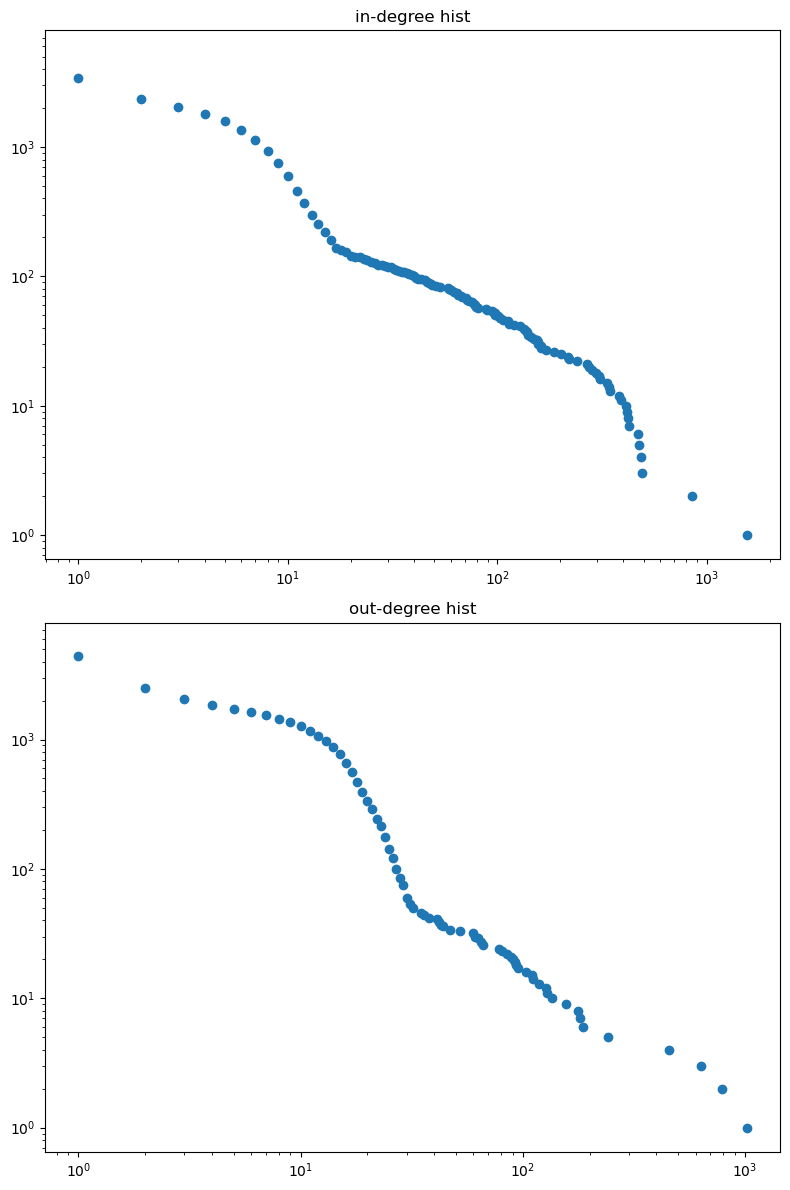

In [3]:
utils.degree_scatter(G_sample,['in','out'],type='count',log=True)

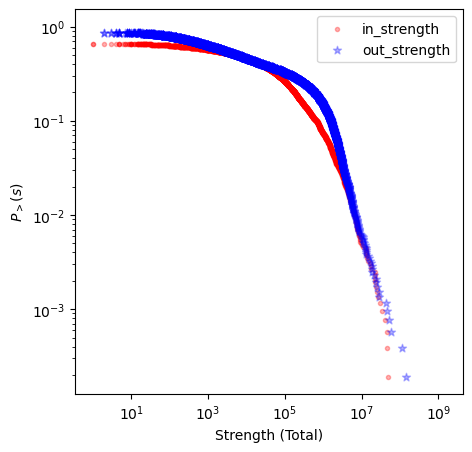

In [4]:
utils.strength_scatter(G_sample,figsize=(5,5))

In [5]:
utils.degree_vs_avgclustering(G_sample)

NameError: name 'defaultdict' is not defined

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [8]:
def get_features(G):
    node_features = {}
    for node in G.nodes():
        in_edges = G.in_edges(node, data=True)
        out_edges = G.out_edges(node, data=True)
        
        in_degree = G.in_degree(node)
        out_degree = G.out_degree(node)
        
        in_strength_total = sum(data['total'] for _, _, data in in_edges)
        out_strength_total = sum(data['total'] for _, _, data in out_edges)
        
        in_strength_count = sum(data['count'] for _, _, data in in_edges)
        out_strength_count = sum(data['count'] for _, _, data in out_edges)
        
        clustering_coefficient = nx.clustering(G.to_undirected(), node)
        
        node_features[node] = [
            in_degree, 
            out_degree, 
            in_strength_total, 
            out_strength_total, 
            in_strength_count, 
            out_strength_count, 
            clustering_coefficient
        ]
    node_features_df = pd.DataFrame.from_dict(node_features,orient='index',
                                              columns=[
            'in_degree', 
            'out_degree', 
            "in_strength_total", 
            'out_strength_total', 
            'in_strength_count', 
            'out_strength_count', 
            "clustering_coefficient"
        ])
    return node_features_df
node_feature_df = get_features(G_sample)

## try different clsutersing in k means

d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super

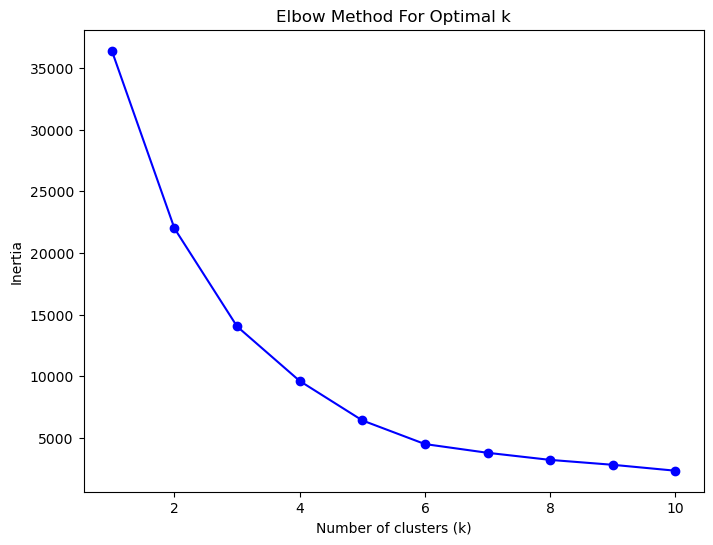

In [10]:
inertia = []
scaler = StandardScaler()
data = node_feature_df.values
normalized_features = scaler.fit_transform(data)
K = range(1, 11)  # Change range as needed

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_features)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [12]:

kmeans = KMeans(n_clusters=6)  # Change n_clusters to your desired number of clusters
kmeans.fit(data)
labels = kmeans.labels_
node_feature_df['cluster'] = labels



d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [13]:
import seaborn as sns
from sklearn.manifold import Isomap

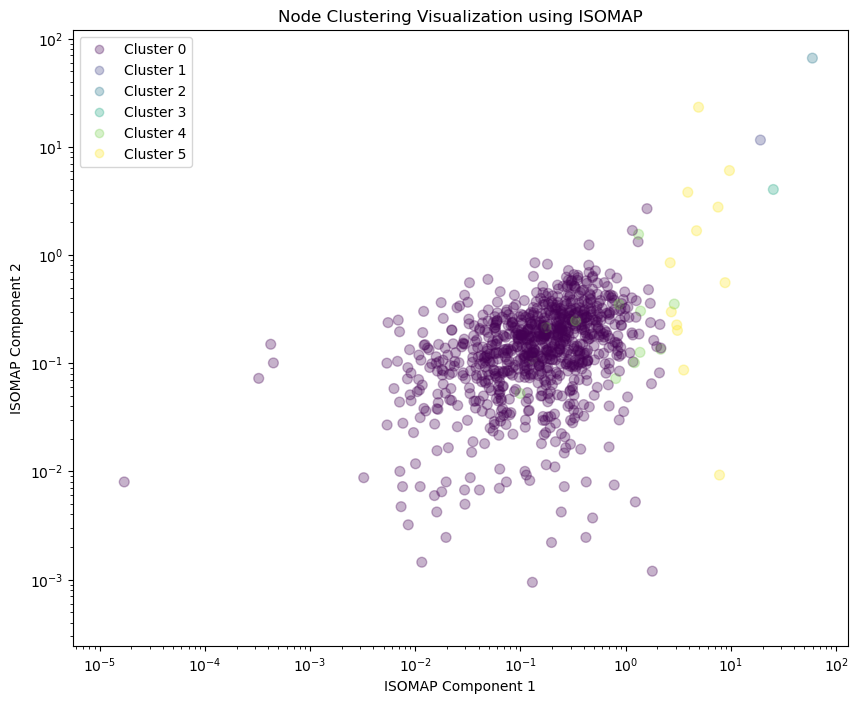

In [19]:
# Apply ISOMAP for dimensionality reduction
# isomap = Isomap(n_components=2)
# reduced_features = isomap.fit_transform(normalized_features)

# Scatter plot of the clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(normalized_features[:,3], normalized_features[:,5], c=labels, cmap='viridis', s=50,alpha=0.3)
plt.title('Node Clustering Visualization using ISOMAP')
plt.xlabel('ISOMAP Component 1')
plt.ylabel('ISOMAP Component 2')
plt.xscale('log',base=10)
plt.yscale('log',base = 10)
plt.legend(handles=scatter.legend_elements()[0], labels=[f'Cluster {i}' for i in range(6)])
plt.show()

In [ ]:
# Add clustering labels to the graph nodes
for node, label in zip(node_feature_df.index(), labels):
    G_sample.nodes[node]['cluster'] = label